In [8]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape
# X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [10]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.ys_prev = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        # Previous output layer
        self.ys_prev.append(0.0)

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        # Previous output layer
        ys_prev_L = []
        for _ in range(L):
            ys_prev_L.append(0.0)
        self.ys_prev.append(ys_prev_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        # Previous output layer
        self.ys_prev.append(0.0)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, _ = l.selu_forward(X=y)
#         if train:
#             y, do_cache = l.dropout_forward(X=y, p_dropout=0.95) # poisson
#             caches.append((fc_cache, do_cache)) # caches[0]
        if train:
            caches.append(fc_cache)
        ys.append(y) # ys[0]
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, ys_L, do_caches = [], [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, _ = l.selu_forward(X=y)
#             if train:
#                 y, do_cache = l.dropout_forward(X=y, p_dropout=0.95) # poisson
#                 do_caches.append(do_cache)
            fc_caches.append(fc_cache)
            ys_L.append(y) # ys[1][layer]
            X = y.copy() # pass to next layer
#         if train:
#             caches.append((fc_caches, do_caches)) # caches[1]
        if train:
            caches.append(fc_caches) # caches[1]
        ys.append(ys_L) # ys[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        if train:
            y, do_cache = l.dropout_forward(X=y, p_dropout=0.95) # poisson
            caches.append((fc_cache, do_cache)) # caches[2]
        ys.append(y) # ys[2]

        return ys, caches # for backpropating the error

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
        
    def train_backward(self, dy, caches):
        grads = self.grads # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache, do_cache = caches[2]
        dy = l.dropout_backward(cache=do_cache, dout=dy)
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
#         fc_caches, do_caches = caches[1]
        fc_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy = l.dropout_backward(cache=do_caches[layer], dout=dy)
#             dy = l.selu_backward(cache=nl_caches[layer], dout=dy)
#             dy = np.exp(dy) #/ np.exp(dy).sum(axis=1).reshape(-1, 1) # txn
            dy *= self.ys[1][layer] - self.ys_prev[1][layer] # function derivative or dfunc
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
#         fc_cache, do_cache = caches[0]
        fc_cache = caches[0]
#         dy = l.dropout_backward(cache=do_cache, dout=dy)
#         dy = l.selu_backward(cache=nl_cache, dout=dy)
#         dy = np.exp(dy) #/ np.exp(dy).sum(axis=1).reshape(-1, 1) # txn
        dy *= self.ys[0] - self.ys_prev[0]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        # dy = dX.copy()
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        ys_logit, _ = self.train_forward(X, train=False)
        y_logit = ys_logit[2] # last layer
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy == acc
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            self.ys, caches = self.train_forward(X_mini, train=True)
#             print(self.ys[2].shape)
            loss, dy = self.loss_function(self.ys[2], y_mini)
            _, grads = self.train_backward(dy, caches) # self.ys_prev is used here for dfunc/ diff
            self.ys_prev = self.ys # for next iteration or epoch
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [11]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 10 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.3086 valid loss: 2.3898, valid accuracy: 0.0918
Iter-20 train loss: 2.3255 valid loss: 2.3897, valid accuracy: 0.0918
Iter-30 train loss: 2.2965 valid loss: 2.3896, valid accuracy: 0.0918
Iter-40 train loss: 2.3115 valid loss: 2.3895, valid accuracy: 0.0918
Iter-50 train loss: 2.3000 valid loss: 2.3893, valid accuracy: 0.0918
Iter-60 train loss: 2.3085 valid loss: 2.3892, valid accuracy: 0.0918
Iter-70 train loss: 2.2994 valid loss: 2.3892, valid accuracy: 0.0918
Iter-80 train loss: 2.3078 valid loss: 2.3890, valid accuracy: 0.0922
Iter-90 train loss: 2.3134 valid loss: 2.3889, valid accuracy: 0.0920
Iter-100 train loss: 2.2832 valid loss: 2.3888, valid accuracy: 0.0918
Iter-110 train loss: 2.3359 valid loss: 2.3886, valid accuracy: 0.0918
Iter-120 train loss: 2.3218 valid loss: 2.3885, valid accuracy: 0.0924
Iter-130 train loss: 2.3092 valid loss: 2.3884, valid accuracy: 0.0924
Iter-140 train loss: 2.3118 valid loss: 2.3883, valid accuracy: 0.0926
Iter-150 train 

Iter-1170 train loss: 2.3107 valid loss: 2.3786, valid accuracy: 0.0924
Iter-1180 train loss: 2.3064 valid loss: 2.3785, valid accuracy: 0.0926
Iter-1190 train loss: 2.3150 valid loss: 2.3784, valid accuracy: 0.0926
Iter-1200 train loss: 2.3001 valid loss: 2.3783, valid accuracy: 0.0930
Iter-1210 train loss: 2.3187 valid loss: 2.3782, valid accuracy: 0.0930
Iter-1220 train loss: 2.3184 valid loss: 2.3781, valid accuracy: 0.0932
Iter-1230 train loss: 2.3066 valid loss: 2.3780, valid accuracy: 0.0932
Iter-1240 train loss: 2.3393 valid loss: 2.3779, valid accuracy: 0.0934
Iter-1250 train loss: 2.3063 valid loss: 2.3778, valid accuracy: 0.0934
Iter-1260 train loss: 2.3053 valid loss: 2.3777, valid accuracy: 0.0934
Iter-1270 train loss: 2.3162 valid loss: 2.3776, valid accuracy: 0.0934
Iter-1280 train loss: 2.2938 valid loss: 2.3775, valid accuracy: 0.0934
Iter-1290 train loss: 2.2758 valid loss: 2.3774, valid accuracy: 0.0934
Iter-1300 train loss: 2.3060 valid loss: 2.3774, valid accuracy:

Iter-2310 train loss: 2.3310 valid loss: 2.3680, valid accuracy: 0.0952
Iter-2320 train loss: 2.3100 valid loss: 2.3679, valid accuracy: 0.0952
Iter-2330 train loss: 2.3089 valid loss: 2.3678, valid accuracy: 0.0952
Iter-2340 train loss: 2.3015 valid loss: 2.3677, valid accuracy: 0.0950
Iter-2350 train loss: 2.3093 valid loss: 2.3676, valid accuracy: 0.0950
Iter-2360 train loss: 2.2904 valid loss: 2.3675, valid accuracy: 0.0950
Iter-2370 train loss: 2.3053 valid loss: 2.3674, valid accuracy: 0.0950
Iter-2380 train loss: 2.2923 valid loss: 2.3673, valid accuracy: 0.0950
Iter-2390 train loss: 2.3022 valid loss: 2.3672, valid accuracy: 0.0950
Iter-2400 train loss: 2.3082 valid loss: 2.3671, valid accuracy: 0.0950
Iter-2410 train loss: 2.3064 valid loss: 2.3670, valid accuracy: 0.0950
Iter-2420 train loss: 2.2968 valid loss: 2.3670, valid accuracy: 0.0950
Iter-2430 train loss: 2.3061 valid loss: 2.3669, valid accuracy: 0.0950
Iter-2440 train loss: 2.3200 valid loss: 2.3668, valid accuracy:

Iter-3450 train loss: 2.3229 valid loss: 2.3575, valid accuracy: 0.0972
Iter-3460 train loss: 2.3043 valid loss: 2.3575, valid accuracy: 0.0972
Iter-3470 train loss: 2.3037 valid loss: 2.3573, valid accuracy: 0.0968
Iter-3480 train loss: 2.2810 valid loss: 2.3572, valid accuracy: 0.0970
Iter-3490 train loss: 2.3296 valid loss: 2.3571, valid accuracy: 0.0968
Iter-3500 train loss: 2.3123 valid loss: 2.3570, valid accuracy: 0.0970
Iter-3510 train loss: 2.3143 valid loss: 2.3569, valid accuracy: 0.0970
Iter-3520 train loss: 2.3165 valid loss: 2.3568, valid accuracy: 0.0970
Iter-3530 train loss: 2.3044 valid loss: 2.3567, valid accuracy: 0.0970
Iter-3540 train loss: 2.3108 valid loss: 2.3566, valid accuracy: 0.0970
Iter-3550 train loss: 2.3043 valid loss: 2.3566, valid accuracy: 0.0970
Iter-3560 train loss: 2.3039 valid loss: 2.3565, valid accuracy: 0.0970
Iter-3570 train loss: 2.2949 valid loss: 2.3564, valid accuracy: 0.0972
Iter-3580 train loss: 2.3251 valid loss: 2.3563, valid accuracy:

Iter-4590 train loss: 2.3073 valid loss: 2.3471, valid accuracy: 0.0988
Iter-4600 train loss: 2.2906 valid loss: 2.3470, valid accuracy: 0.0988
Iter-4610 train loss: 2.3046 valid loss: 2.3470, valid accuracy: 0.0988
Iter-4620 train loss: 2.3058 valid loss: 2.3469, valid accuracy: 0.0988
Iter-4630 train loss: 2.3054 valid loss: 2.3468, valid accuracy: 0.0990
Iter-4640 train loss: 2.2965 valid loss: 2.3466, valid accuracy: 0.0990
Iter-4650 train loss: 2.3046 valid loss: 2.3465, valid accuracy: 0.0990
Iter-4660 train loss: 2.3118 valid loss: 2.3464, valid accuracy: 0.0992
Iter-4670 train loss: 2.2994 valid loss: 2.3463, valid accuracy: 0.0992
Iter-4680 train loss: 2.3059 valid loss: 2.3462, valid accuracy: 0.0992
Iter-4690 train loss: 2.3096 valid loss: 2.3461, valid accuracy: 0.0992
Iter-4700 train loss: 2.2927 valid loss: 2.3460, valid accuracy: 0.0992
Iter-4710 train loss: 2.2985 valid loss: 2.3459, valid accuracy: 0.0992
Iter-4720 train loss: 2.3171 valid loss: 2.3458, valid accuracy:

Iter-5730 train loss: 2.3215 valid loss: 2.3379, valid accuracy: 0.1016
Iter-5740 train loss: 2.2977 valid loss: 2.3377, valid accuracy: 0.1018
Iter-5750 train loss: 2.3068 valid loss: 2.3376, valid accuracy: 0.1016
Iter-5760 train loss: 2.3119 valid loss: 2.3376, valid accuracy: 0.1016
Iter-5770 train loss: 2.3008 valid loss: 2.3375, valid accuracy: 0.1016
Iter-5780 train loss: 2.3106 valid loss: 2.3375, valid accuracy: 0.1016
Iter-5790 train loss: 2.2946 valid loss: 2.3374, valid accuracy: 0.1016
Iter-5800 train loss: 2.3132 valid loss: 2.3373, valid accuracy: 0.1016
Iter-5810 train loss: 2.3082 valid loss: 2.3373, valid accuracy: 0.1016
Iter-5820 train loss: 2.3032 valid loss: 2.3372, valid accuracy: 0.1016
Iter-5830 train loss: 2.3213 valid loss: 2.3372, valid accuracy: 0.1018
Iter-5840 train loss: 2.3097 valid loss: 2.3371, valid accuracy: 0.1018
Iter-5850 train loss: 2.2995 valid loss: 2.3370, valid accuracy: 0.1018
Iter-5860 train loss: 2.3113 valid loss: 2.3369, valid accuracy:

Iter-6870 train loss: 2.3059 valid loss: 2.3290, valid accuracy: 0.1032
Iter-6880 train loss: 2.3106 valid loss: 2.3290, valid accuracy: 0.1032
Iter-6890 train loss: 2.2996 valid loss: 2.3289, valid accuracy: 0.1032
Iter-6900 train loss: 2.3030 valid loss: 2.3288, valid accuracy: 0.1032
Iter-6910 train loss: 2.3125 valid loss: 2.3287, valid accuracy: 0.1034
Iter-6920 train loss: 2.2973 valid loss: 2.3286, valid accuracy: 0.1034
Iter-6930 train loss: 2.3098 valid loss: 2.3285, valid accuracy: 0.1034
Iter-6940 train loss: 2.2918 valid loss: 2.3285, valid accuracy: 0.1036
Iter-6950 train loss: 2.3092 valid loss: 2.3284, valid accuracy: 0.1038
Iter-6960 train loss: 2.3005 valid loss: 2.3283, valid accuracy: 0.1038
Iter-6970 train loss: 2.3099 valid loss: 2.3282, valid accuracy: 0.1036
Iter-6980 train loss: 2.2997 valid loss: 2.3282, valid accuracy: 0.1036
Iter-6990 train loss: 2.3069 valid loss: 2.3280, valid accuracy: 0.1038
Iter-7000 train loss: 2.3192 valid loss: 2.3280, valid accuracy:

Iter-8010 train loss: 2.3148 valid loss: 2.3204, valid accuracy: 0.1062
Iter-8020 train loss: 2.3087 valid loss: 2.3203, valid accuracy: 0.1064
Iter-8030 train loss: 2.3074 valid loss: 2.3202, valid accuracy: 0.1066
Iter-8040 train loss: 2.3216 valid loss: 2.3202, valid accuracy: 0.1062
Iter-8050 train loss: 2.3132 valid loss: 2.3201, valid accuracy: 0.1062
Iter-8060 train loss: 2.3050 valid loss: 2.3200, valid accuracy: 0.1062
Iter-8070 train loss: 2.3067 valid loss: 2.3200, valid accuracy: 0.1062
Iter-8080 train loss: 2.3062 valid loss: 2.3199, valid accuracy: 0.1062
Iter-8090 train loss: 2.3035 valid loss: 2.3198, valid accuracy: 0.1062
Iter-8100 train loss: 2.3210 valid loss: 2.3197, valid accuracy: 0.1064
Iter-8110 train loss: 2.2950 valid loss: 2.3196, valid accuracy: 0.1064
Iter-8120 train loss: 2.2945 valid loss: 2.3196, valid accuracy: 0.1064
Iter-8130 train loss: 2.3186 valid loss: 2.3195, valid accuracy: 0.1064
Iter-8140 train loss: 2.3079 valid loss: 2.3195, valid accuracy:

Iter-9150 train loss: 2.2989 valid loss: 2.3128, valid accuracy: 0.1090
Iter-9160 train loss: 2.3124 valid loss: 2.3127, valid accuracy: 0.1090
Iter-9170 train loss: 2.3194 valid loss: 2.3126, valid accuracy: 0.1090
Iter-9180 train loss: 2.3017 valid loss: 2.3125, valid accuracy: 0.1092
Iter-9190 train loss: 2.3075 valid loss: 2.3125, valid accuracy: 0.1090
Iter-9200 train loss: 2.2974 valid loss: 2.3124, valid accuracy: 0.1088
Iter-9210 train loss: 2.3067 valid loss: 2.3124, valid accuracy: 0.1090
Iter-9220 train loss: 2.2956 valid loss: 2.3124, valid accuracy: 0.1092
Iter-9230 train loss: 2.2928 valid loss: 2.3123, valid accuracy: 0.1092
Iter-9240 train loss: 2.3008 valid loss: 2.3122, valid accuracy: 0.1092
Iter-9250 train loss: 2.3053 valid loss: 2.3121, valid accuracy: 0.1094
Iter-9260 train loss: 2.3134 valid loss: 2.3121, valid accuracy: 0.1092
Iter-9270 train loss: 2.3094 valid loss: 2.3120, valid accuracy: 0.1092
Iter-9280 train loss: 2.2769 valid loss: 2.3119, valid accuracy:

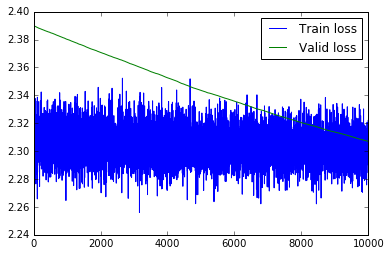

In [12]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

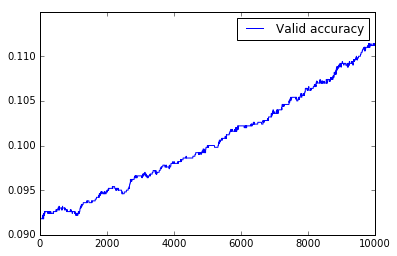

In [13]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()